In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import re
from collections import Counter

# from isoweek import Week
from pandas_summary import DataFrameSummary
import operator
from matplotlib import pyplot as plt
import pickle 

import multiprocessing as mp
import datetime as dt
from tqdm import tqdm_notebook
import scipy.stats as st
import scipy

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns

import keras 
from keras.layers import Input,Dense,Dropout,Flatten,Embedding, merge,LSTM,TimeDistributed,Activation,Bidirectional
from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers.merge import *

%matplotlib inline

Using TensorFlow backend.


### Load and preprocess data

In [3]:
# def fill_nan_median(row,median=early_features_df.early_median):
#     row_copy = row
#     median = early_features_df.early_median[row.name]
    
#     row_copy.fillna(median,inplace=True)
    
#     return row_copy
   

In [2]:
def winsorize_row(row,threshold=0.95,fillna=True):
#     print (type(row))
    row_copy = row
    median =  row[1:].quantile(0.5)#np.median(row[1:])
#     q95 = row[1:].quantile(threshold)
    values =  row[1:]
#     print (median,q95)
    
#     winsorized = pd.Series(st.mstats.winsorize( row[1:], limits=[0.05, 0.05]))
    
    
    if  fillna:
        if not np.isnan(median):
            values.fillna(median, inplace=True)
        else:
            values.fillna(0, inplace=True)

#     values[np.where(values>q95)[0]] = q95
#     print (np.where(values>q95))
    row_copy[1:] = values
    return row_copy

In [174]:
def extract_num_features(row_early_window,threshold=0.95,fillna=True):
    
    
    early_features = []
    
    ### early window 

    early_features.append(row_early_window.quantile(0.25))
    early_features.append(row_early_window.quantile(0.50))
    early_features.append(row_early_window.quantile(0.75))
    early_features.append(row_early_window.quantile(0.95))
    early_features.append(row_early_window.mean())
    early_features.append(row_early_window.isnull().sum())
    early_features.append(np.count_nonzero(np.where(row_early_window==0.)))
    
    
    early_features = np.nan_to_num(np.array(early_features)).tolist()
    
    
    
    return early_features 



In [4]:
dev = pd.read_csv('data/train_1.csv')

In [5]:
dev.fillna(0.0, inplace=True)

In [6]:
train_window_end = dev.shape[1]- 60 #- 10
train_window_end

491

In [187]:
# early_features = dev.iloc[:,1:train_window_end].apply(extract_num_features,axis=1)

# early_features_df = pd.DataFrame(early_features.values.tolist(),
#              columns=["early_25","early_median","early_75","early_95","early_mean","early_nan", "early_0s"])

# early_features_df.to_csv("data/cache/early_features_df.csv",index=False)

# early_features_df.early_mean.shape

In [229]:
#fill na
# dev = dev.apply(fill_nan_median,axis=1)

# dev.to_csv("data/cache/dev_nan_to_early_median.csv",index=False)

# dev.fillna(early_features_df.early_mean,axis=1)#not implemented .. 

# dev.fillna(0., inplace=True)

In [186]:
#cat features only overfit .. 

# page_details = dev.Page.str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<type>.*)')


# fixing nulls

# pages_with_null = dev[page_details.topic.isnull()].iloc[:,:2]

# null_topics = pages_with_null.Page.str.extract(r'(?P<topic>.*)\_.+\..*')

# null_access_type = pages_with_null.Page.str.extract(r'.*\_(?P<access>.*)\_(?P<type>.*)')

# page_details.lang[page_details.lang.isnull()]="na"

# page_details.topic[page_details.topic.isnull()]=null_topics.values

# page_details.access[page_details.access.isnull()]=null_access_type.access.values

# page_details.type[page_details.type.isnull()]=null_access_type.type.values

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


### Train-test split

In [7]:
print (dev.columns.values.tolist().index('2015-07-01'),
dev.columns.values.tolist().index('2016-10-20'), 
       dev.columns.values.tolist().index('2016-10-31'))

(1, 478, 489)


In [8]:
dev.shape[1]

551

In [12]:
del offset

In [13]:
train = dev[['Page']+list(dev.columns[1:train_window_end])]

# train = train.apply(winsorize_row,axis=1)
# train.to_csv("data/cache/train_nantomedian.csv",index=False)

In [14]:
train.tail(2)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31,2016-11-01
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145062,Francisco_el_matemático_(serie_de_televisión_d...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
holdout = dev[['Page']+list(dev.columns[train_window_end:])]

#dev[['Page']+list(dev.columns[train_window_end+10:])] #excluding the 10 day gap

# holdout = holdout.apply(winsorize_row,axis=1)

# holdout.to_csv("data/cache/holdout_nantomedian.csv",index=False)

train.shape,holdout.shape

((145063, 491), (145063, 61))

In [16]:
t_index = np.arange(dev.shape[0])
np.random.seed(19)
np.random.shuffle(t_index)
t_index[0:20]

array([ 76273,  98713,  23152, 134300, 101000,   5420, 101157, 124244,
        47033, 128066,  43026, 138521,  68718, 101233,  46711,  77046,
        32988,  60013,  26117,  59942])

In [225]:
ix_train  = t_index[:int(0.8*len(t_index))]
ix_valid  = t_index[int(0.8*len(t_index)):]

X_train = np.log1p(train.iloc[ix_train,1:].values)
X_valid = np.log1p(train.iloc[ix_valid,1:].values)


#reshaping into 3d for LSTM
X_train = X_train.reshape((-1,1,X_train.shape[1]))
X_valid = X_valid.reshape((-1,1,X_valid.shape[1]))

In [226]:
# Y_train = np.log1p(np.median(holdout.iloc[ix_train,1:].values,axis=1))
# Y_valid = np.log1p(np.median(holdout.iloc[ix_valid,1:].values,axis=1))

In [227]:
# Y_train = np.log1p(holdout.iloc[ix_train,1:].values)
# Y_valid = np.log1p(holdout.iloc[ix_valid,1:].values)

# median_target_train = np.median(Y_train,axis=1)#np.array([np.mean(Y_train)])
# median_target_valid = np.median(Y_valid,axis=1)

In [228]:
Y_train = np.log1p(holdout.iloc[ix_train,1:].values)
Y_valid = np.log1p(holdout.iloc[ix_valid,1:].values)

Y_train = np.median(Y_train,axis=1)#np.array([np.mean(Y_train)])
Y_valid = np.median(Y_valid,axis=1)

In [413]:
# max_log_y = np.max(np.median(np.log1p(dev.iloc[:,1:].values),axis=1))


# max_log_y


# Y_train = Y_train/max_log_y
# Y_valid = Y_valid/max_log_y

In [414]:
# X_sample= X_train[:X_train.shape[0]//2]
# Y_sample= Y_train[:X_train.shape[0]//2]

In [415]:
X_train.shape,X_valid.shape, Y_train.shape, Y_valid.shape

((116050, 1, 490), (29013, 1, 490), (116050,), (29013,))

### Alternative features

In [188]:
def inverse_log1p (arr): return np.rint(np.expm1(arr))
def split_cols(arr): return np.hsplit(arr,arr.shape[1])
def cat_map_info(feat): return feat[0], len(feat[1].classes_)
def cat_preproc(dat):
    return cat_map_fit.transform(dat).astype(np.int64)

In [189]:
cat_var_dict = {'lang':6} #'topic': 200,'access':3, 'type':3
cat_vars = [o[0] for o in 
            sorted(cat_var_dict.items(), key=operator.itemgetter(1), reverse=True)]

In [190]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
cat_maps

[('lang', LabelEncoder())]

In [191]:
# cat_map_train,cat_map_valid,cat_mapper,cat_map_fit = pickle.load(open("data/cache/cat_map_tmp.pickle","rb"))
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(page_details)
cat_cols = len(cat_map_fit.features)


In [192]:
# cat_map_fit.features[3][1].classes_[-10:]

In [193]:
[len(o[1].classes_) for o in cat_map_fit.features]


[8]

In [194]:
cat_map_train = cat_preproc(page_details.iloc[ix_train])
cat_map_valid = cat_preproc(page_details.iloc[ix_valid])
cat_map_test = cat_preproc(page_details)


In [195]:
cat_map_test[10]

array([7])

In [262]:
# pickle.dump([cat_map_train,cat_map_valid,cat_mapper,cat_map_fit],open("data/cache/cat_map_tmp.pickle","wb"))

In [263]:
map_train = split_cols(cat_map_train) + [X_train]
map_valid = split_cols(cat_map_valid) + [X_valid]


### Numerical features


- diffferent widnows 
- median, mean, std, min,max for each window 



In [33]:
# raw_train = pd.read_csv('data/train_1.csv')

# raw_train = raw_train.apply(winsorize_row,fillna=False,axis=1)


# raw_train = pd.read_csv("data/cache/raw_train_winsorized_with_na.csv")

In [28]:
# raw_train_early_window = dev[['Page']+list(raw_train.columns[1:(raw_train.shape[1]- 60 - 10)])]
raw_train_early_window = dev[['Page']+list(dev.columns[1:(dev.shape[1]- 60)])]
raw_train_early_window.shape

(145063, 491)

In [29]:
def get_window_features(row):

    Windows = [6, 12, 18, 30, 48, 78, 126, 203, 329]
    Visits = 0
    
    n = len(row) - 1#train.shape[1] - 1 #  550
#     Visits = np.zeros(train.shape[0])
#     for i, row in train.iterrows():
    M = []
    start = row[1:].nonzero()[0]
    if len(start) == 0:
        return 0
        
    if n - start[0] < Windows[0]:
        Visits = row.iloc[start[0]+1:].median()
        return Visits
        
    for W in Windows:
        if W > n-start[0]:
            break
            
        M.append(row.iloc[-W:].median())
        
    Visits = np.median(M)

#     Visits[np.where(Visits < 1)] = 0.
    # train['Visits'] = Visits
    return Visits

In [30]:
raw_train_early_window["Median_of_Medians"]  = raw_train_early_window.apply(get_window_features,axis=1)
# raw_train_early_window["Median_of_Medians"] = raw_train_early_window.fillna(0).apply(get_window_features,axis=1)

# raw_train_early_window["num_nulls"] = raw_train_early_window.isnull().sum(axis=1)

# raw_train_early_window["num_zeros"] = raw_train_early_window.apply(
#     lambda x: np.count_nonzero(np.where(x[1:-2].values==0.)), axis=1)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [217]:
# raw_train_early_window.drop(["num_zeros","num_nunzeros"],axis=1,inplace=True)

In [41]:
# raw_train_early_window[["Page","num_zeros","num_nulls","Median_of_Medians"]].to_csv("data/cache/Continx4.csv",index=False)

In [35]:
# contin_features = pd.read_csv("data/cache/Continx4.csv")

In [36]:
# raw_train_early_window = pd.concat([raw_train_early_window,contin_features],axis=1)

In [19]:
raw_train_early_window = pd.read_csv("data/cache/Continx1_mom_train.csv")


In [20]:
raw_train_early_window.drop(["Page"],axis=1,inplace=True)

In [468]:
num_features_early = pd.concat([raw_train_early_window,early_features_df],axis=1)

In [469]:
num_features_early.columns.values.tolist()

['Median_of_Medians',
 'early_25',
 'early_median',
 'early_75',
 'early_95',
 'early_mean',
 'early_nan',
 'early_0s']

In [21]:
contin_vars = ['Median_of_Medians']#,'early_median']#'Median_of_Medians']#,"num_nulls","num_zeros"]
contin_maps = [([o], StandardScaler()) for o in contin_vars]


In [22]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(raw_train_early_window)
contin_cols = len(contin_map_fit.features)
contin_cols

1

In [23]:
num_features_early.tail(5)

NameError: name 'num_features_early' is not defined

In [495]:
# contin_map_fit.transform(num_features_early)[0:2]


In [496]:
# raw_train_early_window[["Page","Median_of_Medians"]].to_csv("data/cache/Continx1_mom_train.csv",index=False)

In [24]:
def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)

In [26]:
contin_map_train = contin_preproc(raw_train_early_window.iloc[ix_train])
contin_map_valid = contin_preproc(raw_train_early_window.iloc[ix_valid])


In [27]:
contin_map_train.shape

(116050, 1)

In [196]:
map_train = split_cols(cat_map_train) + [contin_map_train] + [X_train]
map_valid = split_cols(cat_map_valid) + [contin_map_valid] + [X_valid]
# map_train =[contin_map_train] + [X_train]
# map_valid =[contin_map_valid] + [X_valid]

In [197]:
len(map_train)


3

In [502]:
pickle.dump([contin_map_train,contin_map_valid,contin_mapper,contin_map_fit],open("data/cache/contin_map_tmp_x8.pickle","wb"))

In [75]:
# contin_map_train,contin_map_valid,contin_mapper,contin_map_fit = pickle.load(open("data/cache/contin_map_tmp.pickle","rb"))

In [350]:
import xgboost as xgb

In [375]:
num_folds = 5
xgb_params = {
 'eval_metric': 'logloss',
 'learning_rate': 0.25,#8244194429306306,
 'max_depth': 5,
 'n_estimators': 500,
 'objective': 'reg:linear',
'nthread':4,'silent':1}


In [376]:
d_train = xgb.DMatrix(contin_map_train,label= Y_train)#, weight=weight_train)
d_valid = xgb.DMatrix(contin_map_valid,label= Y_valid)#,weight=weight_val)



In [377]:
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(xgb_params, d_train, 10000,  watchlist, early_stopping_rounds=50, verbose_eval=10)#,feval=kapp

[0]	train-logloss:-131.167	valid-logloss:-130.113
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:-137.091	valid-logloss:-136.332
[20]	train-logloss:-137.107	valid-logloss:-136.37
[30]	train-logloss:-137.114	valid-logloss:-136.373
[40]	train-logloss:-137.129	valid-logloss:-136.384
[50]	train-logloss:-137.134	valid-logloss:-136.38
[60]	train-logloss:-137.143	valid-logloss:-136.384
[70]	train-logloss:-137.149	valid-logloss:-136.378
[80]	train-logloss:-137.155	valid-logloss:-136.376
[90]	train-logloss:-137.157	valid-logloss:-136.371
[100]	train-logloss:-137.163	valid-logloss:-136.373
[110]	train-logloss:-137.163	valid-logloss:-136.375
Stopping. Best iteration:
[69]	train-logloss:-137.146	valid-logloss:-136.387



### Create Model

In [198]:

def smape_keras(y_true, y_pred):
    denominator = (K.abs(y_true) + K.abs(y_pred) ) / 200.0 + K.epsilon()
    diff = K.abs(y_true - y_pred) / denominator
#     diff[denominator == 0] = 0.0
    return K.mean(diff)

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)


In [31]:
batch_size = 128

In [243]:
# create and fit the LSTM network

hidden_size = 512 
drop_out = 0.2

model = Sequential()
# model.add(Bidirectional(LSTM(hidden_size,  return_sequences=True, 
#                dropout=drop_out, recurrent_dropout=drop_out),input_shape=( 1,X_train.shape[2],)))

model.add(LSTM(hidden_size,  return_sequences=True, 
               dropout=drop_out, recurrent_dropout=drop_out,input_shape=( 1,X_train.shape[2],)))
# model.add(LSTM(hidden_size,  return_sequences=True, 
#                dropout=drop_out, recurrent_dropout=drop_out))


model.add(TimeDistributed(Dense(hidden_size,activation='relu')))
# model.add(Activation('relu'))
model.add(Flatten())

# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Dense(hidden_size//2, activation='relu'))
# model.add(Dropout(drop_out))

# model.add(Dense(Y_train.shape[1]))
model.add(Dense(1))
model.add(Activation('relu'))




In [244]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3)) #loss='mean_squared_error'
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 1, 512)            2054144   
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 512)            2099200   
_________________________________________________________________
time_distributed_7 (TimeDist (None, 1, 512)            262656    
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 4,416,513
Trainable params: 4,416,513
Non-trainable params: 0
_________________________________________________________________


In [245]:


# MODEL_WEIGHTS_FILE = 'weights/512lstm_{epoch:02d}_val_loss_{val_loss:.2f}.h5'
MODEL_WEIGHTS_FILE = 'weights/LSTMx2_{}_drp{}_mse_nogap_nanto0_notwinsorized_predict_median_fixed.h5'.format(hidden_size,drop_out)

callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_loss', save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=5),
            ReduceLROnPlateau(monitor='val_loss',  patience=3, verbose=1, factor=0.1, min_lr=1e-5)]


In [246]:
MODEL_WEIGHTS_FILE

'weights/LSTMx2_512_drp0.2_mse_nogap_nanto0_notwinsorized_predict_median.h5'

Scores:

- LSTM_512_drp0.2_nanto0_notwinsorized_mse val_loss: 0.6152
- LSTM_512_drp0.2_nantomedian_notwinsorized val_loss: 1.2136
- LSTM_512_drp0.2_nogap_nanto0_notwinsorized: Maximum loss at epoch 33 = 1.0323

- LSTM_512_drp0.2_smape_nogap_nanto0_notwinsorized: epoch 27 = 36.4746

In [247]:
history = model.fit(X_train, Y_train, validation_data=(X_valid,Y_valid),
          epochs=100, callbacks=callbacks, batch_size=batch_size) 

Train on 116050 samples, validate on 29013 samples
Epoch 1/100
116050/116050 [==============================] - 21s - loss: 1.1521 - val_loss: 1.3183
Epoch 2/100
116050/116050 [==============================] - 19s - loss: 0.8002 - val_loss: 0.5584
Epoch 3/100
116050/116050 [==============================] - 18s - loss: 0.6886 - val_loss: 1.0858
Epoch 4/100
116050/116050 [==============================] - 19s - loss: 0.6456 - val_loss: 0.5433
Epoch 5/100
116050/116050 [==============================] - 19s - loss: 0.5663 - val_loss: 1.2429
Epoch 6/100
116050/116050 [==============================] - 19s - loss: 0.5316 - val_loss: 0.3994
Epoch 7/100
116050/116050 [==============================] - 19s - loss: 0.5080 - val_loss: 0.5553
Epoch 8/100
116050/116050 [==============================] - 19s - loss: 0.5052 - val_loss: 0.3485
Epoch 9/100
116050/116050 [==============================] - 19s - loss: 0.4813 - val_loss: 0.3340
Epoch 10/100
116050/116050 [==============================

#### K-folding

In [207]:
from sklearn.model_selection import KFold

In [208]:
batch_size = 128
cum_test_preds = np.zeros((145063, 1))
kf = KFold(n_splits=5)
map_test =  [contin_map_test,X_test]


In [213]:

for ix_train, ix_valid in kf.split(train):    

    X_train = np.log1p(train.iloc[ix_train,1:].values)
    X_valid = np.log1p(train.iloc[ix_valid,1:].values)

    #reshaping into 3d for LSTM
    X_train = X_train.reshape((-1,1,X_train.shape[1]))
    X_valid = X_valid.reshape((-1,1,X_valid.shape[1]))
    

    ### prepare targets
    Y_train = np.log1p(holdout.iloc[ix_train,1:].values)
    Y_valid = np.log1p(holdout.iloc[ix_valid,1:].values)

    Y_train = np.median(Y_train,axis=1)#np.array([np.mean(Y_train)])
    Y_valid = np.median(Y_valid,axis=1)
    
    
    ### prepare model input
    
    contin_map_train = contin_preproc(raw_train_early_window.iloc[ix_train])
    contin_map_valid = contin_preproc(raw_train_early_window.iloc[ix_valid])
    
    map_train =[contin_map_train] + [X_train]
    map_valid =[contin_map_valid] + [X_valid]
    
    ###
    
    model = Model([contin_inp,ts_inp], x)#
    model.compile('adam', "mean_squared_error") #mean_absolute_percentage_error  mean_absolute_error mean_squared_error

    
    history = model.fit(map_train, Y_train, validation_data=(map_valid,Y_valid),
              epochs=100, callbacks=callbacks, batch_size=batch_size) 

    
    model.load_weights(MODEL_WEIGHTS_FILE)
    
    cum_test_preds += model.predict(map_test,verbose=1,batch_size=128)

    
cum_test_preds /= 5.
pickle.dump(cum_test_preds,open("data/cache/cum_test_preds","wb"))    
    

Train on 116050 samples, validate on 29013 samples
Epoch 1/100
116050/116050 [==============================] - 16s - loss: 1.7024 - val_loss: 2.1232
Epoch 2/100
116050/116050 [==============================] - 14s - loss: 0.7028 - val_loss: 0.3273
Epoch 3/100
116050/116050 [==============================] - 14s - loss: 0.5151 - val_loss: 0.4862
Epoch 4/100
116050/116050 [==============================] - 14s - loss: 0.6021 - val_loss: 0.4219
Epoch 5/100
116050/116050 [==============================] - 14s - loss: 0.4653 - val_loss: 0.3112
Epoch 6/100
116050/116050 [==============================] - 14s - loss: 0.4518 - val_loss: 0.3169
Epoch 7/100
116050/116050 [==============================] - 14s - loss: 0.4255 - val_loss: 0.3710
Epoch 8/100
116050/116050 [==============================] - 14s - loss: 0.4273 - val_loss: 0.2875
Epoch 9/100
116050/116050 [==============================] - 14s - loss: 0.4251 - val_loss: 0.3009
Epoch 10/100
116050/116050 [==============================

116051/116051 [==============================] - 14s - loss: 0.4429 - val_loss: 0.1943
Epoch 8/100
115840/116051 [============================>.] - ETA: 0s - loss: 0.4166
Epoch 00007: reducing learning rate to 0.00010000000475.
116051/116051 [==============================] - 14s - loss: 0.4166 - val_loss: 0.2024
Epoch 9/100
116051/116051 [==============================] - 14s - loss: 0.3730 - val_loss: 0.1853
Epoch 10/100
116051/116051 [==============================] - 14s - loss: 0.3661 - val_loss: 0.1824
Epoch 11/100
116051/116051 [==============================] - 14s - loss: 0.3607 - val_loss: 0.1783
Epoch 12/100
116051/116051 [==============================] - 14s - loss: 0.3571 - val_loss: 0.1822
Epoch 13/100
116051/116051 [==============================] - 14s - loss: 0.3529 - val_loss: 0.1755
Epoch 14/100
116051/116051 [==============================] - 14s - loss: 0.3477 - val_loss: 0.1728
Epoch 15/100
116051/116051 [==============================] - 14s - loss: 0.3424 - val

### Multi-intput Model

In [199]:
def get_contin(feat):
    name = feat[0][0]
    inp = Input((1,), name=name+'_in')
    return inp, Dense(1, name=name+'_d', init=my_init(1.))(inp)

In [200]:
def get_emb(feat):
    name, c = cat_map_info(feat)
    #c2 = cat_var_dict[name]
    c2 = (c+1)//2
    if c2>100: c2=100
    print (c,c2)
    inp = Input((1,), dtype='int64', name=name+'_in')
    # , W_regularizer=l2(1e-6)
    u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1, )(inp)) #init=emb_init
#     u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1)(inp))
    return inp,u

In [201]:
embs = [get_emb(feat) for feat in cat_map_fit.features]

(8, 4)


In [202]:
ts_inp = Input((1,X_train.shape[2]), name='ts_input')


In [203]:
contin_inp = Input((contin_cols,), name='contin')
contin_out = Dense(contin_cols*10, activation='relu', name='contin_d')(contin_inp)

In [229]:
# lstm_model = LSTM(512, input_shape=( 1,X_train.shape[2],), return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(ts_inp)
lstm_model = Bidirectional(LSTM(512, return_sequences=True,
                                dropout=0.2, recurrent_dropout=0.2),input_shape=( 1,X_train.shape[2]))(ts_inp)

lstm_model = TimeDistributed(Dense(512,activation='relu'))(lstm_model)
lstm_model = Flatten()(lstm_model)



x = concatenate([emb for inp,emb in embs]+[contin_out,lstm_model]) #contin_out,
# x = concatenate([contin_out,lstm_model]) #contin_out,
x = Dropout(0.05)(x)
x = Dense(512, activation='relu', kernel_initializer='uniform')(x)
x = Dropout(0.3)(x)
x = Dense(1,activation='relu')(x)

# x = Dense(60,activation='relu',name="Y_ts")(Dropout(0.35)(x))
# median_output = Dense(1,activation='relu',name="Y_median")(x)


In [230]:

model = Model([inp for inp,emb in embs] + [contin_inp,ts_inp], x)#contin_inp
# model = Model([contin_inp,ts_inp], [x,median_output])#

# model.compile(Adam(lr=1e-3), 
#               loss=["mean_squared_error","mean_squared_error"],
#               loss_weights=[.5, 1])


# model = Model([contin_inp,ts_inp], x)#
model.compile(Adam(lr=1e-3), 
              loss="mean_squared_error") #mean_absolute_percentage_error  mean_absolute_error mean_squared_error


In [214]:
# model.summary()

In [231]:

# MODEL_WEIGHTS_FILE = 'weights/512lstm_{epoch:02d}_val_loss_{val_loss:.2f}.h5'
MODEL_WEIGHTS_FILE = 'weights/multyinput_BiLSTM_cat1_contin1_mse_nanto0_target_median_fixedY.h5'

callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_loss', save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=5),
            ReduceLROnPlateau(monitor='val_loss',  patience=3, verbose=1, factor=0.1, min_lr=1e-5)]




In [232]:
batch_size = 128
history = model.fit(map_train, Y_train, validation_data=(map_valid,Y_valid),
          epochs=100, callbacks=callbacks, batch_size=batch_size) 


# history = model.fit(map_train, median_target_train, validation_data=(map_valid,median_target_valid),
#           epochs=100, callbacks=callbacks, batch_size=batch_size) 
                    

# history = model.fit(map_train, [Y_train,median_target_train], validation_data=(map_valid,[Y_valid,median_target_valid]),
#           epochs=100, callbacks=callbacks, batch_size=batch_size) 

Train on 116050 samples, validate on 29013 samples
Epoch 1/100
116050/116050 [==============================] - 33s - loss: 1.1249 - val_loss: 0.7387
Epoch 2/100
116050/116050 [==============================] - 26s - loss: 0.6900 - val_loss: 0.6597
Epoch 3/100
116050/116050 [==============================] - 26s - loss: 0.5770 - val_loss: 0.3720
Epoch 4/100
116050/116050 [==============================] - 26s - loss: 0.5319 - val_loss: 0.7610
Epoch 5/100
116050/116050 [==============================] - 26s - loss: 0.4963 - val_loss: 0.3325
Epoch 6/100
116050/116050 [==============================] - 26s - loss: 0.7229 - val_loss: 0.4704
Epoch 7/100
116050/116050 [==============================] - 26s - loss: 0.5199 - val_loss: 0.3389
Epoch 8/100
116050/116050 [==============================] - 26s - loss: 0.4671 - val_loss: 0.4115
Epoch 9/100
115840/116050 [============================>.] - ETA: 0s - loss: 0.4610
Epoch 00008: reducing learning rate to 0.00010000000475.
116050/116050 [=

In [339]:
val_loss: 0.3472
- val_loss: 0.3068 just mom
- 116050/116050 [==============================] - 15s - loss: 0.3412 - val_loss: 0.3172 just 4 contin
116050/116050 [==============================] - 14s - loss: 0.3214 - val_loss: 0.2986  -  4 contin, nanto0
two medians Epoch 26/100
116050/116050 [==============================] - 14s - loss: 0.3133 - val_loss: 0.2911
one median 



SyntaxError: invalid syntax (<ipython-input-339-343c451e63a9>, line 1)

### Check predictions

In [233]:
MODEL_WEIGHTS_FILE

'weights/multyinput_BiLSTM_cat1_contin1_mse_nanto0_target_median_fixedY.h5'

In [234]:
model.load_weights(MODEL_WEIGHTS_FILE)

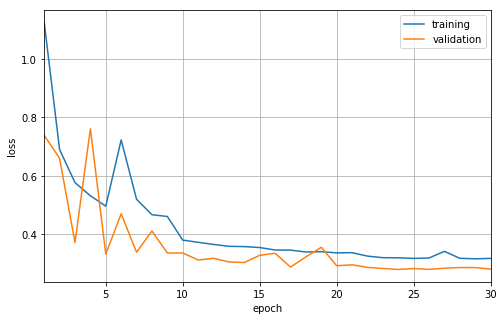

In [235]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['loss'],
                    'validation': history.history['val_loss']})
ax = acc.iloc[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("loss")
# ax.set_ylim([0.0,1.0]);

In [236]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print'Maximum loss at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(min_val_loss)


Maximum loss at epoch 24 = 0.2800


- LSTM 512,0.1 dropout, Maximum loss at epoch 19 = 22.0781
    - Maximum loss at epoch 18 = 30.1040
    - fixed windows: Maximum loss at epoch 23 = 24.9313



- LSTM 512,0.2 dropout, Maximum loss at epoch 32 = 33.1983 
    - nan to median: Maximum loss at epoch 23 = 0.3788
    - nan to
    - BILSTM: Maximum loss at epoch 17 = 0.3694
    - BILSTMx3: Maximum loss at epoch 2 = 0.5430
    
    
    
- LSTM 512, 0.2 dropout, BN, Maximum loss at epoch 19 = 35.1806
- LSTMx2 512,0.2 dropout, Maximum loss at epoch 11 = 33.4731



- LSTM 1024, 0.2 drooutout Maximum loss at epoch 9 = 25.4243
    - extra dense 0.3921 (incomplete .. 43 epochs )

- LSTM 1024, 0.1 drooutout Maximum loss at epoch 2 = 28.5591


##### multi-input (Lstm + catx4) 
- ('Maximum loss at epoch', '55', '=', '0.3361') 0.3361
- smape: ('Maximum loss at epoch', '19', '=', '12.9727') LB: 
- multyinput_LSTM_cat3_mse: ('Maximum loss at epoch', '19', '=', '0.3579')
- nowinsorization-nanto0, mse: 0.3286


##### catx4 continx1 
multyinput_LSTM_cat4_con1_mse
- mse, ('Maximum loss at epoch', '23', '=', '0.2438')

##### catx4 continx3 
multyinput_LSTM_cat4_con3_mse
- mse, val_loss: 0.2125
- mse, second try ('Maximum loss at epoch', '60', '=', '0.2147')
- mae ('Maximum loss at epoch', '39', '=', '0.3133')



#### predict median:
- LSTM_512_drp0.2_mse_nogap_nanto0_notwinsorized_predict_median : epoch 34 = 0.2900
- cat4: multyinput_LSTM_cat4_mse_nanto0_nowinsorized_predict_mean (should be predict median): epoch 26 = 0.1460
- multyinput_LSTM_contin1_mse_nanto0_nowinsorized_nobuffer_predict_median: epoch 36 = 0.2874
- multyinput_LSTM_cat3_contin1_mse_nanto0_nowinsorized_nobuffer_predict_median: epoch 37 = 0.2670
- multioutput val_Y_ts_loss: 0.6162 - val_Y_median_loss: 0.2856
- multioutput bilstm: val_Y_ts_loss: 0.6058 - val_Y_median_loss: 0.2820
- cat 1 ,contin 1: Maximum loss at epoch 24 0.2800

In [41]:
# model.load_weights("weights/LSTM_512_drp0.2_nantomedian.h5")

In [237]:
val_preds = model.predict(map_valid,verbose=1,batch_size=128)
# val_preds = model.predict(X_valid,verbose=1,batch_size=128)

28544/29013 [============================>.] - ETA: 0s

In [66]:
15933  26170

SyntaxError: invalid syntax (<ipython-input-66-84cce67890c4>, line 1)

In [238]:
val_preds_inv = np.exp(val_preds)-1

In [239]:
val_preds_inv.min() , val_preds_inv.max()

(0.0, 6030001.5)

In [240]:
# Y_train = np.log1p(holdout.iloc[ix_train,1:].values)
Y_valid = np.log1p(holdout.iloc[ix_valid,1:].values)

In [241]:
scores_simple = []
for i in range(val_preds.shape[0]):
#     scores_simple.append(smape(np.exp(Y_valid[i])-1 ,np.rint(np.expm1(val_preds[i]) )))
    scores_simple.append(smape(np.exp(Y_valid[i])-1 ,np.rint([np.expm1(val_preds[i])]*60 )))

scores_simple = np.array(scores_simple)


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide


In [242]:
scores_simple.min(),scores_simple.max(),scores_simple.mean(),scores_simple.std()

(0.0, 2.0, 0.46577228315852004, 0.30983121157016447)

In [102]:
scores_simple.min(),scores_simple.max(),scores_simple.mean(),scores_simple.std()

(0.0, 2.0, 0.46352698753805355, 0.31437741086815074)

In [181]:
scores_simple.min(),scores_simple.max(),scores_simple.mean(),scores_simple.std()

(0.0, 2.0, 0.47164563051941771, 0.31165477763194954)

-predict median: (0.0, 2.0, 0.47164563051941771, 0.31165477763194954)


In [104]:
scores = np.array(scores)
scores.min(),scores.max(),scores.mean(),scores.std()

(0.0, 2.0, 0.3246142903582489, 0.22016414843827431)

(array([  180.,   826.,  2720.,  3791.,  3921.,  3652.,  3180.,  2566.,
         1962.,  1440.,  1027.,   725.,   566.,   430.,   356.,   270.,
          230.,   172.,   130.,   113.,    82.,    77.,    49.,    54.,
           38.,    37.,    28.,    46.,    47.,   298.]),
 array([ 0.        ,  0.06666667,  0.13333333,  0.2       ,  0.26666667,
         0.33333333,  0.4       ,  0.46666667,  0.53333333,  0.6       ,
         0.66666667,  0.73333333,  0.8       ,  0.86666667,  0.93333333,
         1.        ,  1.06666667,  1.13333333,  1.2       ,  1.26666667,
         1.33333333,  1.4       ,  1.46666667,  1.53333333,  1.6       ,
         1.66666667,  1.73333333,  1.8       ,  1.86666667,  1.93333333,  2.        ]),
 <a list of 30 Patch objects>)

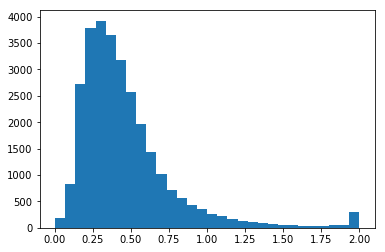

In [103]:
plt.hist(np.array(scores_simple),bins=30)

(array([  273.,   553.,  2259.,  3605.,  4041.,  3870.,  3417.,  2789.,
         2232.,  1598.,  1140.,   840.,   533.,   418.,   315.,   233.,
          191.,   119.,   117.,    81.,    59.,    47.,    44.,    40.,
           24.,    28.,    21.,    24.,    22.,    80.]),
 array([ 0.        ,  0.06666667,  0.13333333,  0.2       ,  0.26666667,
         0.33333333,  0.4       ,  0.46666667,  0.53333333,  0.6       ,
         0.66666667,  0.73333333,  0.8       ,  0.86666667,  0.93333333,
         1.        ,  1.06666667,  1.13333333,  1.2       ,  1.26666667,
         1.33333333,  1.4       ,  1.46666667,  1.53333333,  1.6       ,
         1.66666667,  1.73333333,  1.8       ,  1.86666667,  1.93333333,  2.        ]),
 <a list of 30 Patch objects>)

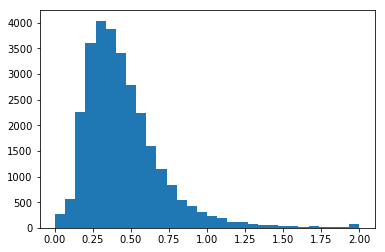

In [282]:
plt.hist(np.array(scores_simple),bins=30)

In [79]:
scores = []
for i in tqdm_notebook(range(val_preds.shape[0])):
    scores.append(smape(np.exp(Y_valid[i])-1 ,np.rint(np.exp(val_preds[i])-1 )))

Widget Javascript not detected.  It may not be installed or enabled properly.


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


(array([  3.77000000e+02,   3.77400000e+03,   5.87600000e+03,
          4.38700000e+03,   3.46200000e+03,   3.02300000e+03,
          2.39100000e+03,   1.71600000e+03,   1.19700000e+03,
          8.02000000e+02,   5.19000000e+02,   3.94000000e+02,
          2.54000000e+02,   1.72000000e+02,   1.69000000e+02,
          1.29000000e+02,   8.80000000e+01,   7.10000000e+01,
          5.70000000e+01,   3.80000000e+01,   2.50000000e+01,
          2.30000000e+01,   1.90000000e+01,   1.20000000e+01,
          1.20000000e+01,   8.00000000e+00,   3.00000000e+00,
          5.00000000e+00,   6.00000000e+00,   4.00000000e+00]),
 array([ 0.        ,  0.06666667,  0.13333333,  0.2       ,  0.26666667,
         0.33333333,  0.4       ,  0.46666667,  0.53333333,  0.6       ,
         0.66666667,  0.73333333,  0.8       ,  0.86666667,  0.93333333,
         1.        ,  1.06666667,  1.13333333,  1.2       ,  1.26666667,
         1.33333333,  1.4       ,  1.46666667,  1.53333333,  1.6       ,
         1.66

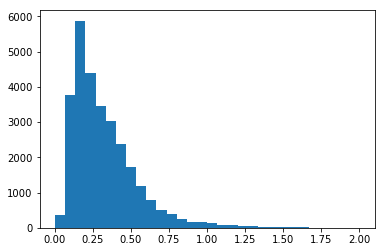

In [87]:
plt.hist(np.array(scores),bins=30)

In [70]:
Y_valid[ts_id].shape

(60,)

8315
median: 273.0
SMAPE: 0.377465972131


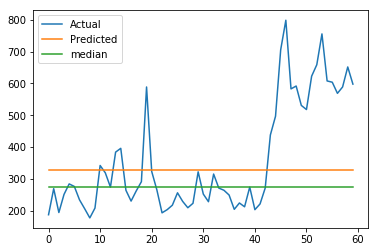

In [155]:
ts_id = np.random.randint(val_preds.shape[0]) # take a random sample
print (ts_id)

# md = np.median(np.exp(X_valid[ts_id].ravel()))-1
md = np.rint(np.exp(np.median(Y_valid[ts_id])))
print "median:",md
print "SMAPE:",smape(np.exp(Y_valid[ts_id])-1 , [np.exp(val_preds[ts_id])-1]*60)  #np.rint(np.exp(val_preds[ts_id])-1 ))

plt.plot(np.exp(Y_valid[ts_id])-1, label = 'Actual')
# plt.plot(np.exp(val_preds[ts_id])-1,  label = 'Predicted')
plt.plot([np.rint(np.exp(val_preds[ts_id])-1)]*60,  label = 'Predicted')
plt.plot([md]*60,label='median')
# plt.xlabel('Index of Page')
# plt.ylabel('Mean Web View')

plt.legend()

plt.show()

### Make prediction

In [163]:
def winsorize_row_0(row,threshold=0.95,fillna=True):
    median =  row.quantile(0.5)#np.median(row[1:])
    values =  row
    
    
    if  fillna:
        if not np.isnan(median):
            values.fillna(median, inplace=True)
        else:
            values.fillna(0, inplace=True)

    return values

In [104]:
key_1 = pd.read_csv('data/key_1.csv')
# train = pd.read_csv('data/train_1.csv')
# ss_1 = pd.read_csv('data/sample_submission_1.csv')


In [105]:
key_1.shape, dev.shape

((8703780, 2), (145063, 551))

In [106]:
dev.shape

(145063, 551)

In [107]:
X_train.shape[2] 

490

In [243]:
window_end = dev.shape[1] #-10
window_start  = window_end - X_train.shape[2] 
print (window_start, window_end)


(61, 551)


In [244]:
# dev_nantomedian_test = dev.iloc[:,window_start:window_end] #.apply(winsorize_row_0,axis=1)

# dev_nantomedian_test.tail(2)

In [245]:

X_test = dev.iloc[:,window_start:window_end] 
#dev_nantomedian_test #dev_nantomedian_test[list(dev.columns[window_start:window_end])]
X_test = np.log1p(X_test.values)
X_test = X_test.reshape((-1,1,X_test.shape[1]))

In [246]:
cat_map_train.shape , cat_map_valid.shape

((116050, 1), (29013, 1))

In [247]:
cat_map_test = cat_preproc(page_details) #test set is full training set

##### recalculate numerical features for late window

In [73]:
# raw_train.to_csv("data/cache/raw_train_winsorized_with_na.csv",index=False)

In [96]:
# raw_train_late_window = dev[['Page']+list(dev.columns[window_start:window_end])]
# raw_train_late_window["Median_of_Medians"] = raw_train_late_window.apply(get_window_features,axis=1)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [114]:
# raw_train_late_window = raw_train[['Page']+list(raw_train.columns[window_start:window_end])]


# raw_train_late_window["Median_of_Medians"] = raw_train_late_window.fillna(0).apply(get_window_features,axis=1)
# raw_train_late_window["num_nulls"] = raw_train_late_window.isnull().sum(axis=1)
# raw_train_late_window["num_zeros"] = raw_train_late_window.apply(
#     lambda x: np.count_nonzero(np.where(x[1:-2].values==0.)), axis=1)



# raw_train_late_window[["Page","num_zeros","num_nulls","Median_of_Medians"]].to_csv("data/cache/Continx4_test.csv",index=False) 
# raw_train_late_window = pd.read_csv("data/cache/Continx4_test.csv")

# raw_train_late_window[["Page","Median_of_Medians"]].to_csv("data/cache/Continx1_mom_test.csv",index=False) 
raw_train_late_window = pd.read_csv("data/cache/Continx1_mom_test.csv")
contin_map_test = contin_preproc(raw_train_late_window)
   



In [248]:

# map_test = [contin_map_test,X_test]

map_test = split_cols(cat_map_test) + [contin_map_test] + [X_test]


In [100]:
np.max(dev.iloc[:,5:].values)

67264258.0

In [249]:
# map_test = split_cols(cat_map_test) + [X_test]

test_preds = model.predict(map_test,verbose=1,batch_size=128)


144512/145063 [============================>.] - ETA: 0s

In [250]:
# test_preds = model.predict(X_test,batch_size=128)


test_preds= (np.rint(np.expm1(test_preds))).astype(np.int64)


In [216]:
test_preds = cum_test_preds
test_preds= (np.rint(np.expm1(test_preds))).astype(np.int64)


In [251]:
test_preds.min(),test_preds.max(),test_preds.argmax()

(0, 6389392, 40930)

In [252]:
np.where(test_preds==6389392)

(array([40930]), array([0]))

#### create submission df

In [253]:
test_dates = key_1.iloc[0:61].Page.str.split("_")
date_columns = []
for i in range(60):
    date_columns.append (test_dates[i][4])

In [254]:
preds_df = pd.DataFrame(index=dev.Page,data=np.ones((test_preds.shape[0],60)),columns=date_columns)
preds_df.head(2)

,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2017-02-20,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-25,2017-02-26,2017-02-27,2017-02-28,2017-03-01
Page,,,,,,,,,,,,,,,,,,,,,
2NE1_zh.wikipedia.org_all-access_spider,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2PM_zh.wikipedia.org_all-access_spider,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [255]:
from tqdm import tqdm_notebook,tqdm

In [256]:
for i in tqdm(range(len(preds_df))):
    preds_df.iloc[i] = test_preds[i]

100%|██████████| 145063/145063 [00:19<00:00, 7408.69it/s]


In [258]:
preds_df.head(2)

,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2017-02-20,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-25,2017-02-26,2017-02-27,2017-02-28,2017-03-01
Page,,,,,,,,,,,,,,,,,,,,,
2NE1_zh.wikipedia.org_all-access_spider,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
2PM_zh.wikipedia.org_all-access_spider,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,...,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0


In [169]:
test_preds[116196]

array([1225175])

median: 1582.0


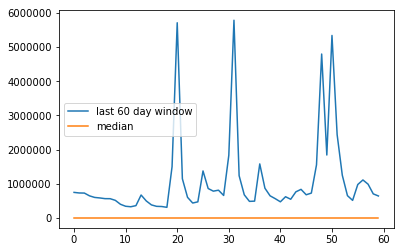

In [260]:
ts_id = 40930#116196#40930
# np.random.randint(dev.shape[0]) # take a random sample
# print (ts_id)

#67049

md = np.median(np.rint(np.exp(X_test[ts_id].ravel())-1))
print "median:",md
# print "SMAPE:",smape(np.exp(Y_valid[ts_id])-1 ,np.rint(np.exp(val_preds[ts_id])-1 ))

plt.plot(np.expm1(X_test[ts_id,0,-60:]), label = 'last 60 day window')
# plt.plot(test_preds[ts_id],  label = 'Predicted')
plt.plot([md]*60,label='median')
# plt.xlabel('Index of Page')
# plt.ylabel('Mean Web View')

plt.legend()

plt.show()

### Submission

In [261]:
preds_df.reset_index(inplace=True)
preds_df = preds_df.melt(id_vars="Page",var_name='date', value_name='Visits')

preds_df.head(5)


,Page,date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2017-01-01,20.0
1,2PM_zh.wikipedia.org_all-access_spider,2017-01-01,23.0
2,3C_zh.wikipedia.org_all-access_spider,2017-01-01,5.0
3,4minute_zh.wikipedia.org_all-access_spider,2017-01-01,18.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2017-01-01,14.0


In [262]:
predicted_visists = preds_df.Visits

In [263]:
# preds_df.to_csv("data/cache/preds_df.csv",index=False)
preds_df= pd.read_csv("data/cache/preds_df.csv")

In [264]:
preds_df.Visits = predicted_visists

In [265]:
submission = pd.merge(key_1,preds_df[["Page","Visits"]],on="Page")

In [266]:
submission.isnull().sum()

Page      0
Id        0
Visits    0
dtype: int64

In [267]:
submission.drop(["Page"], axis=1, inplace=True)

In [268]:
MODEL_WEIGHTS_FILE

'weights/multyinput_BiLSTM_cat1_contin1_mse_nanto0_target_median_fixedY.h5'

In [269]:
submission.to_csv("subm/{}.csv".format("multyinput_BiLSTM_cat1_contin1_mse_nanto0_target_median_fixedY"),index=False)

In [190]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8703780 entries, 0 to 8703779
Data columns (total 2 columns):
Id        object
Visits    int64
dtypes: int64(1), object(1)
memory usage: 199.2+ MB


In [112]:
# from IPython.lib.display import FileLink
# FileLink("subm/lstm_512_0.1.csv")
#submission via command line

In [191]:
submission.min()

Id        00000004df28
Visits               0
dtype: object

In [202]:
np.where(predicted_visists>0)[0].shape, predicted_visists.shape

((8551602,), (8703780,))

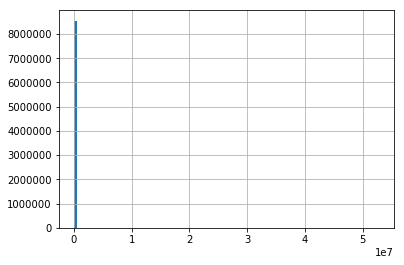

In [204]:
predicted_visists[np.where(predicted_visists>0)[0]].hist(bins=100)

In [206]:
predicted_visists.mean(), predicted_visists.median(), predicted_visists.max(), predicted_visists.min()

(1194.813669692938, 138.0, 52752124, 0)